In [1]:
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Dropout, Flatten, BatchNormalization
from keras.models import Model, Sequential
from keras import activations
from keras import optimizers
from keras import losses
from keras import initializers

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd

# Load and visualization of Data

In [2]:
FILE = "./../datasets/height-weight/weight-height.csv"
df = pd.read_csv(FILE)
df = df[df.columns[1:]][:5000]
df

,Height,Weight
0,73.847017,241.893563
1,68.781904,162.310473
2,74.110105,212.740856
3,71.730978,220.042470
4,69.881796,206.349801
...,...,...
4995,68.860062,177.131052
4996,68.973423,159.285228
4997,67.013795,199.195400
4998,71.557718,185.905909


In [3]:
data = df.values

Text(0, 0.5, 'Weight, pounds')

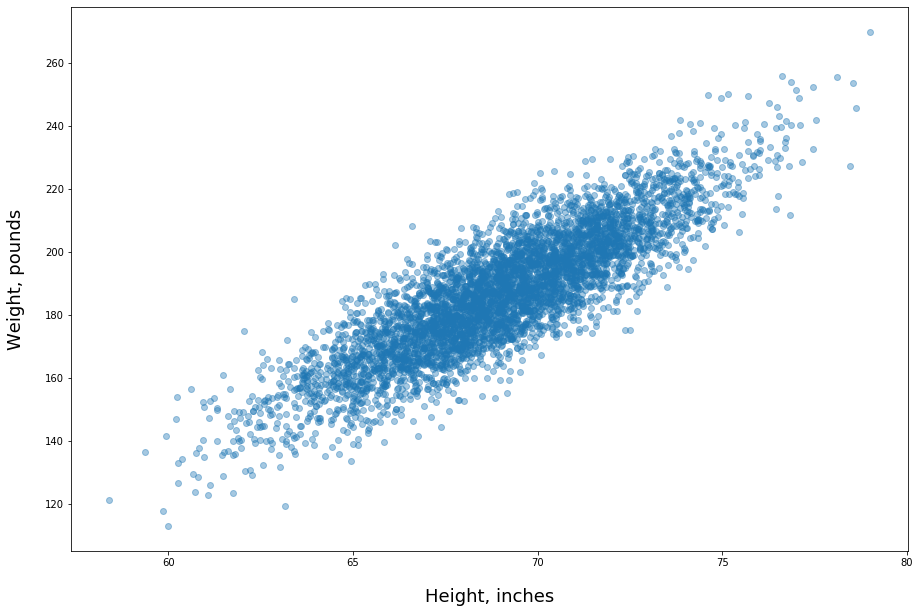

In [4]:
plt.figure(figsize=(15, 10))
plt.scatter(data[:, 0], data[:, 1], alpha=0.4)
plt.xlabel('Height, inches', fontsize=18, labelpad=20)
plt.ylabel('Weight, pounds', fontsize=18, labelpad=20)

# GAN

In [34]:
def get_generator(dim):
    generator = Sequential([
        Flatten(input_shape=[dim]),
        BatchNormalization(),
        Dense(40, kernel_initializer=initializers.he_normal(), activation='elu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(30, activation='elu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(30, activation='elu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(2, activation='elu')
    ])
    generator.compile(loss=losses.mean_squared_error, optimizer=optimizers.Adam())
    return generator

In [35]:
def get_discriminator(dim):
    discriminator = Sequential([
        Flatten(input_shape=[dim]),
        BatchNormalization(),
        Dense(350, kernel_initializer=initializers.he_normal(), activation='elu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(256, activation='elu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(170, activation='elu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(64, activation='elu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(1, activation='sigmoid')
    ])
    discriminator.compile(loss=losses.BinaryCrossentropy(), optimizer=optimizers.Adam())
    return discriminator

In [36]:
def get_gan_network(discriminator, generator, dim):
    discriminator.trainable = False
    gan_input = Input(shape=(dim,))
    
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizers.Adam())
    return gan

# Train the network

In [37]:
def train(data, epochs=100, batch_size=32):
    data_train, data_test = train_test_split(data, test_size=0.3)
    batch_count = len(data_train) // batch_size
    
    dim = 2
    generator = get_generator(dim)
    discriminator = get_discriminator(dim)
    gan = get_gan_network(discriminator, generator, dim)
    
    for e in range(1, epochs+1):
        print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in range(batch_count):
            noise = np.random.normal(0, 1, size=[batch_size, dim])
            batch = data_train[np.random.randint(0, data_train.shape[0], size=batch_size)]

            generated_data = generator.predict(noise)
            X = np.concatenate([batch, generated_data])

            # Labels for generated and real data
            y_dis = np.zeros(2*batch_size)
            # One-sided label smoothing
            y_dis[:batch_size] = 1

            # Train discriminator
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_dis)

            # Train generator
            noise = np.random.normal(0, 1, size=[batch_size, dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)
            
        predicted = generator.predict(np.random.normal(0, 1, size=[1, dim]))
        print(predicted)
            
    return generator, discriminator

In [38]:
generator, discriminator = train(data, epochs=60)

--------------- Epoch 1 ---------------
[[-0.15410322  0.5276088 ]]
--------------- Epoch 2 ---------------
[[0.7738864 0.1144557]]
--------------- Epoch 3 ---------------
[[15.1783695 -0.5537288]]
--------------- Epoch 4 ---------------
[[14.96633   -0.6982112]]
--------------- Epoch 5 ---------------
[[11.958184  -0.7833309]]
--------------- Epoch 6 ---------------
[[ 5.169954   -0.64182687]]
--------------- Epoch 7 ---------------
[[36.36931    -0.99999994]]
--------------- Epoch 8 ---------------
[[-0.9987427 12.463992 ]]
--------------- Epoch 9 ---------------
[[-0.9999361 25.667671 ]]
--------------- Epoch 10 ---------------
[[66.62666 -1.     ]]
--------------- Epoch 11 ---------------
[[47.01954 -1.     ]]
--------------- Epoch 12 ---------------
[[-1.      87.97891]]
--------------- Epoch 13 ---------------
[[-1.     99.9188]]
--------------- Epoch 14 ---------------
[[-0.9986619 12.74136  ]]
--------------- Epoch 15 ---------------
[[72.96754 -1.     ]]
--------------- Epoch 

In [39]:
predicted = generator.predict(np.random.normal(0, 1, size=[5000, 2]))

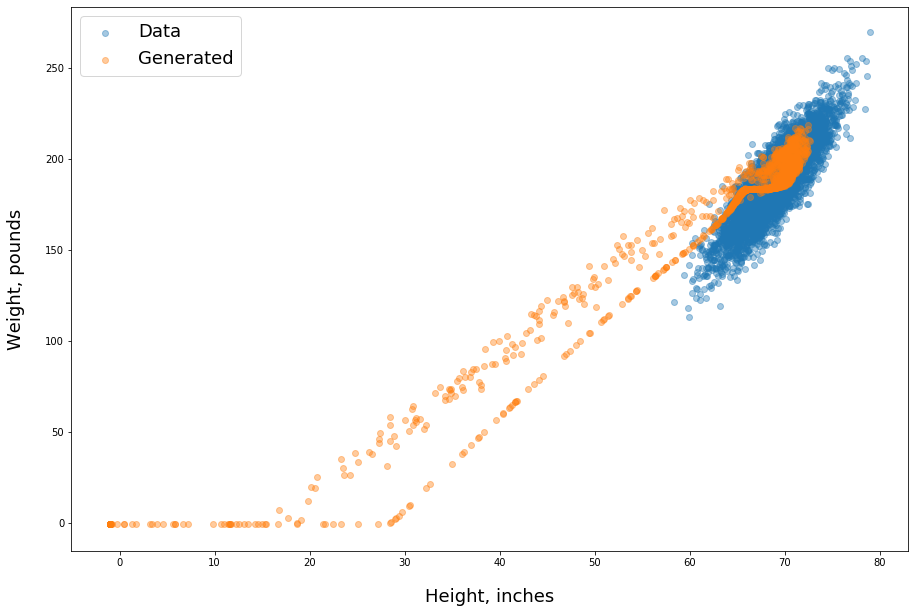

In [40]:
plt.figure(figsize=(15, 10))
plt.scatter(data[:, 0], data[:, 1], alpha=0.4, label="Data")
plt.scatter(predicted[:, 0], predicted[:, 1], alpha=0.4, label="Generated")
plt.xlabel('Height, inches', fontsize=18, labelpad=20)
plt.ylabel('Weight, pounds', fontsize=18, labelpad=20)
plt.legend(loc='upper left', fontsize=18)

# Количество ошибочно предсказанных 

In [41]:
predicted[predicted[:, 0] < 60].shape

(319, 2)

Процент ошибочных:

In [43]:
predicted[predicted[:, 0] < 60].shape[0] / 5000 * 100

6.38